In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

#import data
df = pd.read_csv('data/Recidivism_Data_cleaned.csv')
df_original = df.copy()

# We only want to predict recidivism within 3 years
#We are also looking at just Males
df.drop(['Recidivism_Arrest_Year1', 'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3', 'Gender'], axis=1, inplace=True)

### Data Preprocessing

In [2]:
#Chance all Booleans to Integers
for column in df.columns:
    if df[column].dtype == 'bool':
        df[column] = df[column].astype(int)

# Dummy Variable for Race 
df['Race'] = df['Race'].map({'BLACK': 1, 'WHITE': 0})

# Change age to integer as opposed to float
df['Age_at_Release'] = df['Age_at_Release'].astype(int)

# Interger Encoded to for embeddings in NN
df['Prison_Offense'] = df['Prison_Offense'].map({category: idx for idx, category in enumerate(df['Prison_Offense'].unique())})
df['Education_Level'] = df['Education_Level'].map({'Less than HS diploma': 0, 'High School Diploma': 1, 'At least some college': 2})
df['Supervision_Level_First'] = df['Supervision_Level_First'].map({'Standard': 0, 'High': 1, 'Specialized': 2})

# Make Recidivism_Within_3years the last column
cols = [col for col in df.columns if col != 'Recidivism_Within_3years']
cols.append('Recidivism_Within_3years')
df = df[cols]

In [3]:
# Variables to normalize
columns_to_normalize = ['Age_at_Release', 'Prison_Years', 'Supervision_Risk_Score_First', 'Percent_Days_Employed', 'Jobs_Per_Year']  # add other columns here

# Apply Standardization
scaler = StandardScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

#Split Train and Test Data
train_df = df[df['Training_Sample'] == 1]
test_df = df[df['Training_Sample'] == 0]
train_df = train_df.drop(columns=['Training_Sample'])
test_df = test_df.drop(columns=['Training_Sample'])


### MLP

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [5]:
class DataFrameDataset(Dataset):
    def __init__(self, dataframe):
        """
        Args:
            dataframe (pd.DataFrame): source data
        """
        # Assuming the last column is the label
        self.features = dataframe.iloc[:, :-1].values
        self.labels = dataframe.iloc[:, -1].values

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Convert features and labels to tensors
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return features, label


In [6]:
#Convert pd dataframe to torch dataset
train_dataset = DataFrameDataset(train_df)
test_dataset = DataFrameDataset(train_df)

# use 15% of training data for validation
train_set_size = int(len(train_dataset) * 0.85)
valid_set_size = len(train_dataset) - train_set_size
train_set, valid_set = torch.utils.data.random_split(train_dataset, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(42))

# DataLoaders
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
total_train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [7]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Create fully connected layers (nn.Linear)
        ### START CODE ###
        self.fc1 = nn.Linear(47, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)
        ### END CODE ###

    def forward(self, x):
        ### START CODE ###
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        ### END CODE ###
        return x


In [8]:
model = MLP()
# Create the optimizer
### START CODE ###
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
### END CODE ###

In [9]:
# Create the loss function instance
criterion = torch.nn.BCEWithLogitsLoss()

def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    total_num = 0
    for data, target in tqdm(loader):
        out = model(data)
        # Calculate loss based on model output and target
        ### START CODE ###
        target = target.unsqueeze(1) 
        loss = criterion(out, target.float())
        ### END CODE ###

        # Use the optimizer to perform backpropagation
        ### START CODE ###
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ### END CODE ###

        batch_size = len(target)
        total_loss += loss.item() * batch_size
        total_num += batch_size
    avg_loss = total_loss / total_num
    return avg_loss

@torch.no_grad()
def eval(model, loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_num = 0
    for data, target in tqdm(loader):
        out = model(data)
        # Calculate loss based on model output and target
        ### START CODE ###
        target = target.unsqueeze(1) 
        loss = criterion(out, target.float())
        ### END CODE ###

        # Get model's prediction
        ### START CODE ###
        pred = torch.sigmoid(out) >= 0.5
        ### END CODE ###

        # Count number of correct predictions
        ### START CODE ###
        correct = (pred.float() == target.float()).sum().item()
        ### END CODE ###

        total_correct += correct
        batch_size = len(target)
        total_loss += loss.item() * batch_size
        total_num += batch_size
    avg_loss = total_loss / total_num
    acc = total_correct / total_num
    return avg_loss, acc


In [10]:
epochs = 15
for e in range(1, epochs + 1):
    train_loss = train(model, train_loader, optimizer)
    val_loss, val_acc = eval(model, val_loader)
    print(f"Epoch: {e} Train Loss: {train_loss} Val Loss: {val_loss} Val Acc: {val_acc}")

100%|██████████| 10/10 [00:00<00:00, 562.53it/s]


Epoch: 1 Train Loss: 0.6317617781097153 Val Loss: 0.5853485560537792 Val Acc: 0.6960370994940978


100%|██████████| 10/10 [00:00<00:00, 561.27it/s]


Epoch: 2 Train Loss: 0.5786627403317893 Val Loss: 0.5605934620104592 Val Acc: 0.7166947723440135


100%|██████████| 10/10 [00:00<00:00, 568.57it/s]


Epoch: 3 Train Loss: 0.5631918013295439 Val Loss: 0.5529007932790013 Val Acc: 0.7188026981450253


100%|██████████| 10/10 [00:00<00:00, 560.26it/s]


Epoch: 4 Train Loss: 0.5573979932705343 Val Loss: 0.5470782326405608 Val Acc: 0.7280775716694773


100%|██████████| 10/10 [00:00<00:00, 598.49it/s]


Epoch: 5 Train Loss: 0.5524043792796212 Val Loss: 0.5453302509467075 Val Acc: 0.7209106239460371


100%|██████████| 10/10 [00:00<00:00, 581.97it/s]


Epoch: 6 Train Loss: 0.54913071643491 Val Loss: 0.5445187651688895 Val Acc: 0.7217537942664418


100%|██████████| 10/10 [00:00<00:00, 574.92it/s]


Epoch: 7 Train Loss: 0.5483686520111455 Val Loss: 0.5520591628290148 Val Acc: 0.7179595278246206


100%|██████████| 10/10 [00:00<00:00, 580.86it/s]


Epoch: 8 Train Loss: 0.5438751419595207 Val Loss: 0.5456037298221813 Val Acc: 0.7297639123102867


100%|██████████| 10/10 [00:00<00:00, 609.27it/s]


Epoch: 9 Train Loss: 0.5405361718813555 Val Loss: 0.5437448283070054 Val Acc: 0.7293423271500843


100%|██████████| 10/10 [00:00<00:00, 574.51it/s]


Epoch: 10 Train Loss: 0.5368575088342161 Val Loss: 0.5423594769498751 Val Acc: 0.7225969645868465


100%|██████████| 10/10 [00:00<00:00, 602.18it/s]


Epoch: 11 Train Loss: 0.5337524826802157 Val Loss: 0.5438208550868107 Val Acc: 0.7188026981450253


100%|██████████| 10/10 [00:00<00:00, 604.22it/s]


Epoch: 12 Train Loss: 0.5317809290142231 Val Loss: 0.5426382991354944 Val Acc: 0.7268128161888702


100%|██████████| 10/10 [00:00<00:00, 598.08it/s]


Epoch: 13 Train Loss: 0.5294518887318088 Val Loss: 0.5419106318616947 Val Acc: 0.7314502529510961


100%|██████████| 10/10 [00:00<00:00, 592.74it/s]


Epoch: 14 Train Loss: 0.527747421882383 Val Loss: 0.5425118402928164 Val Acc: 0.71964586846543


100%|██████████| 10/10 [00:00<00:00, 612.78it/s]

Epoch: 15 Train Loss: 0.5235964380272868 Val Loss: 0.5469122247591388 Val Acc: 0.718381112984823


In [11]:
@torch.no_grad()
def test_accuracy(model, loader):
    model.eval()
    total_correct = 0
    total_num = 0
    all_preds = []
    all_targets = []
    all_probs = []  # To store probability estimates

    for data, target in loader:
        out = model(data)
        pred = torch.sigmoid(out) >= 0.5
        correct = (pred.float() == target.unsqueeze(1).float()).sum().item()

        total_correct += correct
        total_num += len(target)

        all_preds.extend(pred.view(-1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        all_probs.extend(torch.sigmoid(out).cpu().numpy())  # Store probability estimates

    acc = total_correct / total_num
    return acc, all_preds, all_targets, all_probs  # Return probability estimates

test_acc, all_preds, all_targets, all_probs = test_accuracy(model, test_loader)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Test Accuracy: 73.80%


In [12]:
@torch.no_grad()
def test_roc_auc(model, loader):
    model.eval()
    all_preds = []
    all_targets = []

    for data, target in loader:
        out = model(data)
        pred = torch.sigmoid(out)
        
        all_preds.extend(pred.view(-1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    roc_auc = roc_auc_score(all_targets, all_preds)
    return roc_auc

In [13]:
from sklearn.metrics import brier_score_loss

roc_auc = test_roc_auc(model, test_loader)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

# Calculate the Brier Score using probability estimates
test_acc, _, _, all_probs = test_accuracy(model, test_loader)
brier_score = brier_score_loss(all_targets, all_probs)
print(f"Brier Score on Test Set: {brier_score:.4f}")

ROC AUC Score on Test Set: 0.8068
Brier Score on Test Set: 0.1754


In [14]:
epochs = 15
for e in range(1, epochs + 1):
    train_loss = train(model, total_train_loader, optimizer)  # Use total_train_loader
    val_loss, val_acc = eval(model, val_loader)
    print(f"Epoch: {e} Train Loss: {train_loss} Val Loss: {val_loss} Val Acc: {val_acc}")

# After training, evaluate on the test set
test_acc, all_preds, all_targets, all_probs = test_accuracy(model, test_loader)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


100%|██████████| 10/10 [00:00<00:00, 577.97it/s]


Epoch: 1 Train Loss: 0.5256750891831574 Val Loss: 0.5356419528716733 Val Acc: 0.725548060708263


100%|██████████| 10/10 [00:00<00:00, 595.02it/s]


Epoch: 2 Train Loss: 0.5236935047050497 Val Loss: 0.5353117573120542 Val Acc: 0.7217537942664418


100%|██████████| 10/10 [00:00<00:00, 601.43it/s]


Epoch: 3 Train Loss: 0.5230294845696231 Val Loss: 0.5298926540812192 Val Acc: 0.7263912310286678


100%|██████████| 10/10 [00:00<00:00, 568.22it/s]


Epoch: 4 Train Loss: 0.5189877240920638 Val Loss: 0.5308508095009532 Val Acc: 0.7276559865092749


100%|██████████| 10/10 [00:00<00:00, 590.12it/s]


Epoch: 5 Train Loss: 0.5201217541884037 Val Loss: 0.5262644612568024 Val Acc: 0.7259696458684655


100%|██████████| 10/10 [00:00<00:00, 575.54it/s]


Epoch: 6 Train Loss: 0.5164469404552627 Val Loss: 0.5217407485485881 Val Acc: 0.7381956155143339


100%|██████████| 10/10 [00:00<00:00, 588.27it/s]


Epoch: 7 Train Loss: 0.5149757897489686 Val Loss: 0.5213084128413594 Val Acc: 0.7293423271500843


100%|██████████| 10/10 [00:00<00:00, 596.59it/s]


Epoch: 8 Train Loss: 0.5133222325968113 Val Loss: 0.5189964685834078 Val Acc: 0.7381956155143339


100%|██████████| 10/10 [00:00<00:00, 600.46it/s]


Epoch: 9 Train Loss: 0.512386968029374 Val Loss: 0.5144649655581727 Val Acc: 0.7331365935919055


100%|██████████| 10/10 [00:00<00:00, 602.30it/s]


Epoch: 10 Train Loss: 0.5093913125807854 Val Loss: 0.5135351586301652 Val Acc: 0.7318718381112985


100%|██████████| 10/10 [00:00<00:00, 586.92it/s]


Epoch: 11 Train Loss: 0.5095385616768561 Val Loss: 0.5130858777144305 Val Acc: 0.7352445193929174


100%|██████████| 10/10 [00:00<00:00, 614.97it/s]


Epoch: 12 Train Loss: 0.5079302025598289 Val Loss: 0.5092661702411774 Val Acc: 0.7386172006745363


100%|██████████| 10/10 [00:00<00:00, 607.65it/s]


Epoch: 13 Train Loss: 0.5085796994152953 Val Loss: 0.5110782794968475 Val Acc: 0.7411467116357504


100%|██████████| 10/10 [00:00<00:00, 595.11it/s]


Epoch: 14 Train Loss: 0.505648618084182 Val Loss: 0.5032505709646524 Val Acc: 0.7403035413153457


100%|██████████| 10/10 [00:00<00:00, 617.41it/s]


Epoch: 15 Train Loss: 0.5045416438973883 Val Loss: 0.5064708492004047 Val Acc: 0.7411467116357504
Test Accuracy: 75.68%


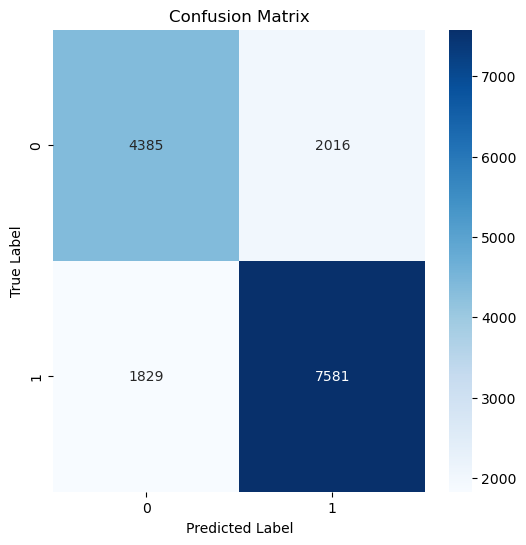

In [15]:
# Calculate the confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [16]:
@torch.no_grad()
def test_roc_auc(model, loader):
    model.eval()
    all_preds = []
    all_targets = []

    for data, target in loader:
        out = model(data)
        pred = torch.sigmoid(out)
        
        all_preds.extend(pred.view(-1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    roc_auc = roc_auc_score(all_targets, all_preds)
    return roc_auc

roc_auc = test_roc_auc(model, test_loader)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

ROC AUC Score on Test Set: 0.8281
